In [9]:
directory = 'C:\\Data_Competitions\\Facebook image matching\\FB_image_matching_competition\\'
data_directory = directory + 'data\\'
training_image_path = data_directory + 'training_images\\'
ref_image_path = data_directory + 'reference_images\\'
query_image_path = data_directory + 'query_images\\'
ground_truth_csv = directory + 'public_ground_truth.csv'

In [16]:
import os
from timeit import default_timer as timer
from datetime import timedelta

In [12]:
import pandas as pd
import numpy as np
def converter(instr):
    return np.fromstring(instr[1:-1],sep=' ')
df_query = pd.read_csv('triplet_loss//query_embedding_semihard12.csv',converters={'embedding':converter})
df_ref = pd.read_csv('triplet_loss//ref_embedding_semihard12.csv',converters={'embedding':converter})

In [13]:
len(df_query)

50000

In [18]:
df_ref = df_ref.rename(columns={0:'image_id',1:'embedding'}).set_index('image_id')
df_query = df_query.rename(columns={0:'image_id',1:'embedding'}).set_index('image_id')
df_ref.sort_index(inplace=True)
df_query.sort_index(inplace=True)

In [14]:
from sklearn.metrics import pairwise_distances
def calculate_distance(df1,df2):
    result = []
    dis_matrix = pairwise_distances(np.stack(df1.iloc[:,0]), np.stack(df2.iloc[:,0]), metric = 'euclidean', n_jobs = 3)
    dis_argmin = dis_matrix.argmin(axis = 1)
    dis_min = np.amin(dis_matrix,axis=1)
    for i in range(len(df1.index.values)):
        index2 = df2.index[dis_argmin[i]]
        index1 = df1.index.values[i]
        result.append((index1, index2, dis_min[i]))
    return result

In [19]:
# Unable to allocate 373. GiB for an array with shape (50000, 1000000) with data type float64 (That's the memory cost for calculate pairwise_distance for the full entire embedding matrixes pair), so had to chunk streaming it
start = timer()
step_size = 100 #50000/50 = 100
path = 'triplet_loss//result_pre_semihard12.csv'
if os.path.exists(path):
    # clear out existing files
    os.remove(path)
for i in range(0, len(df_query), step_size):
    result = calculate_distance(df_query[i:i+step_size], df_ref)
    df_temp = pd.DataFrame(result, columns=['query_id', 'reference_id', 'score']).set_index('query_id')
    df_temp.to_csv(path, mode='a', header=not os.path.exists(path))  # only print header if first time creating the csv file
    processed = i + step_size
    if (processed % 1000 == 0):
        # print progress
        end = timer()
        anticipate_remain = (end - start) * (len(df_query) - processed) / processed
        print("{} : processed {} so far, remain time {}".format(timedelta(seconds=end-start), processed, timedelta(seconds=anticipate_remain)))

0:00:54.094280 : processed 1000 so far, remain time 0:44:10.619725
0:01:47.821121 : processed 2000 so far, remain time 0:43:07.706897
0:02:41.469413 : processed 3000 so far, remain time 0:42:09.687466
0:03:35.287879 : processed 4000 so far, remain time 0:41:15.810607
0:04:29.293986 : processed 5000 so far, remain time 0:40:23.645875
0:05:24.044428 : processed 6000 so far, remain time 0:39:36.325802
0:06:20.052414 : processed 7000 so far, remain time 0:38:54.607688
0:07:15.003251 : processed 8000 so far, remain time 0:38:03.767066
0:08:10.318132 : processed 9000 so far, remain time 0:37:13.671490
0:09:05.290686 : processed 10000 so far, remain time 0:36:21.162746
0:10:00.058816 : processed 11000 so far, remain time 0:35:27.481256
0:10:54.845806 : processed 12000 so far, remain time 0:34:33.678386
0:11:49.664260 : processed 13000 so far, remain time 0:33:39.813663
0:12:44.627489 : processed 14000 so far, remain time 0:32:46.184970
0:13:39.565885 : processed 15000 so far, remain time 0:31

In [29]:
result_pre = pd.read_csv('triplet_loss//result_pre_semihard12.csv')

result_pre

,query_id,reference_id,score
0,Q00000,R157013,0.031178
1,Q00001,R025777,0.033598
2,Q00002,R174604,0.021397
3,Q00003,R060214,0.017128
4,Q00004,R138981,0.006321
...,...,...,...
49995,Q49995,R465310,0.033689
49996,Q49996,R845258,0.067957
49997,Q49997,R275104,0.032076
49998,Q49998,R336998,0.019187


In [30]:
result_pre.groupby('score').count().head(20)

,query_id,reference_id
score,,
0.000000e+00,1,1
2.980232e-08,1,1
2.014024e-05,1,1
5.086764e-05,1,1
6.643293e-05,1,1
7.151188e-05,1,1
8.995443e-05,1,1
2.928786e-04,1,1
3.438782e-04,1,1


<AxesSubplot:>

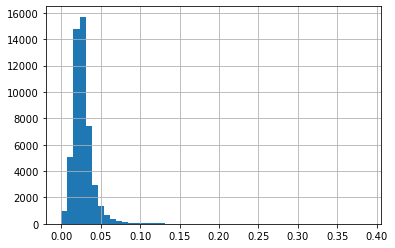

In [31]:
result_pre['score'].hist(bins = 50)


In [32]:
# change distance value <5.0 to 5.0
result_pre.loc[result_pre['score'] < 2.014024e-05, 'score'] = 2.014024e-05

In [26]:
result_pre.groupby('score').count().head(20)

,query_id,reference_id
score,,
0.000020,2,2
0.000020,1,1
0.000051,1,1
0.000066,1,1
0.000072,1,1
0.000090,1,1
0.000293,1,1
0.000344,1,1
0.000409,1,1


In [33]:
result_pre.score = 0.002 / result_pre.score

In [34]:
result_pre.set_index('query_id').to_csv("triplet_loss//result_final_semihard12.csv")